# Introduction

This Audience Clusters Project is my personal project developed to strengthen my understanding of unsupervised learning and its application in large-scale audience data. The goal is to explore how users naturally group together based on their movie viewing patterns and genre ratings, and to uncover meaningful audience segments without relying on predefined labels.

This is a data-driven project, meaning the analysis is guided by the behavior and characteristics of the data rather than a specific prediction task. Instead of beginning with a fixed hypothesis, the approach allows the data itself to reveal patterns and insights-highlighting differences in engagement levels, genre preferences, and rating tendencies among user clusters.
From these observed behaviors, content and marketing strategies are then defined for each audience segment, aligning platform actions with real viewing patterns and satisfaction trends.

Specifically, I apply the K-Means algorithm, an unsupervised learning technique that partitions users into clusters based on their viewing and rating behavior across genres. To visualize these clusters and interpret user differences more intuitively, I use Principal Component Analysis (PCA) purely for visualization purposes, projecting high-dimensional user data into a two-dimensional space that highlights the main patterns of variation.

# Finding

This analysis segments about 266K audiences from MovieLens dataset into five behavioral clusters based on movie counts and average genre ratings.
Each cluster represents a distinct engagement pattern from light casual watchers to highly active, loyal users.

By linking viewing intensity with high-rating behavior (≥3), we identify opportunities for activation, growth, retention, and churn prevention.
The table below summarizes each cluster’s characteristics and provides actionable content and marketing strategies to enhance engagement and satisfaction.

| **Cluster**                                         | **Profile Summary**                                                                                                 | **High-Rated Genres (≥3)**                                                               | **Content / Product Strategy**                                                                                                       | **Marketing & Engagement Actions**                                                                                                                                |
| --------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------ | ----------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **New Explorers**                        | Avg **9 movies/user**. <br> Light casual users showing moderate interest, especially in emotional and mainstream genres. | *Drama, Thriller, Comedy*                                                                | Personalize based on top genres to reduce choice overload. Curate a “Quick Picks” or “Tonight’s Watch” list with trending titles.    | Targeted push notifications (Drama/Thriller), onboarding playlists (“Start with Top 5 in Comedy”), and watch-streak or first-10 rewards to encourage consistency. |
| **Expanding Enthusiasts**                          | Avg **18 movies/user**. <br> Positive sentiment with moderate frequency; open to multiple genres.                        | *9/20 genres* high-rated (Drama, Romance, Thriller, Action)                              | Encourage cross-genre exploration (“If you liked Drama, try Thriller”). Highlight series/franchises to boost repeat engagement.      | Run personalized discovery campaigns, introduce achievement badges, and create genre-challenge events to sustain interest.                                        |
| **Quiet Viewers (Churn Risk)**               | Avg **5 movies/user** <br> Lowest engagement and low satisfaction (<3 ratings across genres).                           | *None consistently ≥3*                                                                   | Focus on quality-over-quantity: promote only top-rated or editor-curated titles. Simplify recommendations to avoid overwhelm.        | Send re-engagement campaigns (“We think you’ll love these picks”), collect feedback via surveys, and offer watch credits to reactivate usage.                     |
| **Loyalists (Heavy Positive Viewers)** | Avg **69 movies/user** <br> Strong engagement and broad satisfaction across genres.                                     | *14/20 genres* (except for TV Movie, Foreign, Western and Animation - rated below 2.5)         | Implement advanced personalization; recommend new releases, niche titles, and sequels in their preferred genres.                     | Offer early access/previews, social sharing features, and VIP reward programs for loyal users.                                                                    |
| **Premium Loyalists**                            | Avg **135 movies/user** <br> The most active and satisfied viewers; high ratings across nearly all genres.              | *15/20 genres* (all genres were rated above 2.5) | Recommend diverse, long-form, and international content to sustain novelty. Apply hybrid recommendation models (content + behavior). | Create VIP or ambassador programs, beta-tester opportunities, and personalized “Year in Review” summaries to reinforce connection and loyalty.                    |


# Import Libraries

These are the core Python libraries required to set up the project environment. They handle essential tasks such as data manipulation, visualization, preprocessing, and clustering.

In [17]:
# Core
import numpy as np
import pandas as pd
from pathlib import Path
import warnings, logging, math, json, gc
from typing import List, Dict, Tuple

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ML & preprocessing
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

# Utilities
from tqdm.auto import tqdm


# Import Dataset from Kaggle

The MovieLens dataset is imported directly from Kaggle using the kagglehub library.

Two CSV files are loaded for analysis:

- "movies_metadata.csv" contains movie details and genres

- "ratings.csv" includes user ratings from users.

In [18]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rounakbanik/the-movies-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/khanhvyho/.cache/kagglehub/datasets/rounakbanik/the-movies-dataset/versions/7


In [19]:
from pathlib import Path
import pandas as pd, warnings
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

DATA_DIR = Path(path)  
movies = pd.read_csv(DATA_DIR / "movies_metadata.csv") # dataset 1: movies
ratings = pd.read_csv(DATA_DIR / "ratings.csv")        # dataset 2: ratings


# Data Wrangling and Exploration

Introduction about 2 datasets:

1. "movies" dataset contains 45,466 observations (rows) of 25 variables (columns). Variables of interest include: "genres", "id", and "original_title".
 
2. "ratings" dataset contains 26,024,289 observations (rows) of 4 variables (columns). These are "userId", "movieId", "rating", and "timestamp".

## Step 1: Clean the "movies" dataset

### Step 1a: Clean "genre" column

In the "movies" dataset, the "genres" column is the variable of interest that needed to work on before analysis. Each movie can belong to more than one genre - for example, Toy Story (1995) is classified under Animation, Comedy, and Family.

- The genre values are ready for analysis; for example, Toy Story's genre appears as "[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]". 

- Our goal in this step is to extract and clean them into the format [Animation, Comedy, Family].

In [20]:
import pandas as pd, ast

# Clean "genres" column
def to_genre_names(x):
    if pd.isna(x) or x == "" or x == "[]":
        return []
    # If it's a string like "[{'id': 35, 'name': 'Comedy'}, ...]" → parse it
    if isinstance(x, str):
        try:
            x = ast.literal_eval(x)
        except Exception:
            return []
    # Now x should be a list of dicts; keep only names
    return [d.get("name") for d in x if isinstance(d, dict) and d.get("name")]

movies["genre_names"] = movies["genres"].apply(to_genre_names)

In [21]:
print(movies["genre_names"].head())

0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
2               [Romance, Comedy]
3        [Comedy, Drama, Romance]
4                        [Comedy]
Name: genre_names, dtype: object


In the current "movies" dataset, we now have a new column named "genre_names" that contains the cleaned movie genres in the desired format for analysis.

### Step 1b: Define number of unique genres 

In [22]:
# Explodes the genre_names lists to rows, drops resulting NaNs only in that temporary Series, and returns the sorted set of unique genres without changing the original DataFrame
unique_genres = sorted(movies["genre_names"].explode().dropna().unique())
print("There are:", len(unique_genres), "unique genres.")
print(unique_genres)

There are: 32 unique genres.
['Action', 'Adventure', 'Animation', 'Aniplex', 'BROSTA TV', 'Carousel Productions', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'GoHands', 'History', 'Horror', 'Mardock Scramble Production Committee', 'Music', 'Mystery', 'Odyssey Media', 'Pulser Productions', 'Rogue State', 'Romance', 'Science Fiction', 'Sentai Filmworks', 'TV Movie', 'Telescene Film Group Productions', 'The Cartel', 'Thriller', 'Vision View Entertainment', 'War', 'Western']


After examining the unique genres, 12 out of 32 were identified as invalid entries. For example, “Mardock Scramble Production Committee” or “Odyssey Media.”

Strategy: Determine how many observations contain these invalid genres.

- If the number is small, drop them.

- If the number is large, conduct further investigation before deciding.

### Step 1c: Define invalid genres and eliminate invalid genres from the dataset

In [23]:
import pandas as pd
import re
import ast

valid_genres = ["Action","Adventure","Animation","Comedy","Crime","Documentary","Drama","Family",
    "Fantasy","Foreign","History","Horror","Music","Mystery","Romance","Science Fiction",
    "TV Movie","Thriller","War","Western"]

VALID = set(valid_genres)

In [24]:
def normalize(s: str) -> str:
    return re.sub(r"\s+", " ", str(s)).strip()

def to_list_of_names(x):
    """Return a list[str] of genre names from x (list/dict/string/None)."""
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return []
    if isinstance(x, list):
        out = []
        for e in x:
            if isinstance(e, dict) and "name" in e:
                out.append(normalize(e["name"]))
            else:
                out.append(normalize(e))
        return out
    if isinstance(x, str):
        # try to parse strings like "[{'id':..., 'name':'Comedy'}, ...]" or "['Drama','Comedy']"
        try:
            parsed = ast.literal_eval(x)
            return to_list_of_names(parsed)
        except Exception:
            return [normalize(x)]
    return [normalize(x)]

movies["genre_names"] = movies["genre_names"].apply(to_list_of_names)


In [25]:
unique_genres = sorted({g for lst in movies["genre_names"] for g in lst})
print("Unique labels found:", unique_genres)
print("Invalid labels (vs your valid 20):", sorted(set(unique_genres) - VALID))


Unique labels found: ['Action', 'Adventure', 'Animation', 'Aniplex', 'BROSTA TV', 'Carousel Productions', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'GoHands', 'History', 'Horror', 'Mardock Scramble Production Committee', 'Music', 'Mystery', 'Odyssey Media', 'Pulser Productions', 'Rogue State', 'Romance', 'Science Fiction', 'Sentai Filmworks', 'TV Movie', 'Telescene Film Group Productions', 'The Cartel', 'Thriller', 'Vision View Entertainment', 'War', 'Western']
Invalid labels (vs your valid 20): ['Aniplex', 'BROSTA TV', 'Carousel Productions', 'GoHands', 'Mardock Scramble Production Committee', 'Odyssey Media', 'Pulser Productions', 'Rogue State', 'Sentai Filmworks', 'Telescene Film Group Productions', 'The Cartel', 'Vision View Entertainment']


In [26]:
# Flag rows within dataset that have invalid genres
has_invalid = movies["genre_names"].apply(lambda lst: any(g not in VALID for g in lst))
has_invalid.value_counts(dropna=False)


genre_names
False    45463
True         3
Name: count, dtype: int64

Fortunately, there are only 3 rows/observations contain invalid genres. Comparing to the size of dataset, it's insignificant. Therefore, they are dropped. 

In [27]:
# Drop rows that has invalid genres
movies_clean = movies.loc[~has_invalid].copy()
print(f"Dropped {int(has_invalid.sum())} rows; kept {len(movies_clean)} rows.")


Dropped 3 rows; kept 45463 rows.


In [28]:
# Drop rows with empty genre lists
movies_clean = movies_clean.loc[movies_clean["genre_names"].map(len) > 0].copy()
print(f"After removing empties: {len(movies_clean)} rows.")

After removing empties: 43021 rows.


After dropping titles with invalid movies and those without genre information, we have 43,021 observations remaining. Moving forward, our analysis will focus on these 43,021 distinct movies.

## Step 2: One-hot encoding

After cleaning invalid entries, we need to convert the list of genres (e.g., [Animation, Comedy, Family]) into a numerical format that can be used for clustering or machine learning models.
- What is one-hot encoding? One-hot encoding transforms categorical values (like genre names) into binary indicator columns.
- In this case, each genre becomes its own column, where: 1 indicates the movie belongs to that genre, and 0 indicates it does not. Example below:

    | Movie Title | Animation | Comedy | Family |
    |-------------|:---------:|:------:|:------:|
    | *Toy Story* (1995) | 1 | 1 | 1 |

In [29]:
# Drop invalid genre columns if any exist
label_set = set(unique_genres)   
movies_clean = movies_clean.drop(columns=list(label_set), errors="ignore")

# One-hot encode with 20 valid genres
s = movies_clean["genre_names"].explode()
dummies = (
    pd.crosstab(s.index, s)
      .clip(upper=1)
      .reindex(columns=valid_genres, fill_value=0)
      .astype("int8")
      .reindex(index=movies_clean.index, fill_value=0)
)

# Attach the clean dummies
movies_clean = movies_clean.join(dummies)

# Double-check to ensure no invalid genre columns remain
assert not any(col in movies_clean.columns for col in (label_set - set(valid_genres)))

# Export
movies_clean.to_csv("movies_with_genres_onehot.csv", index=False)

## Step 3: Merge 2 datasets

At this step, we need to join the "movies_clean" and "ratings" datasets using an inner join to keep only rows with matching movie IDs.

In [30]:
movies_clean["id"] = pd.to_numeric(movies_clean["id"], errors="coerce").astype("Int64")
movies_clean["id"].dtype

movies_ratings = ratings.merge(movies_clean, left_on="movieId", right_on="id", how="inner")

In [31]:
len(movies_ratings)

11382421

There are about 11.3 million individual rating records (each row = one user rating for one movie) in "movies_ratings" dataset.

In [32]:
movies_ratings.to_csv("movies_ratings.csv", index=False)

In [33]:
movies_ratings["userId"].nunique() #There are 265848 users we will analyze

265848

After merging the two datasets on the userId column, there are approximately 266,000 unique users in the "movies_rating" dataset. Then, all the unecessary columns will be excluded from "dataset". This new "dataset" will be used for the next part: feature engineering.

In [34]:
dataset = movies_ratings.filter(items=["userId","movieId","rating","original_title", "genre_names",
                                       "Action", "Adventure", "Animation", "Comedy", "Crime", "Documentary", "Drama", "Family", "Fantasy", "Foreign",
                                       "History", "Horror", "Music", "Mystery", "Romance", "Science Fiction", "TV Movie", "Thriller", "War", "Western"]).copy()

Example of an observation in "dataset":

| userId | movieId | rating | original_title           | genre_names               | Action | Adventure | Animation | Comedy | Crime | History | Horror | Music | Mystery | Romance | Science Fiction | TV Movie | Thriller | War | Western |
| :----- | :------ | :----- | :----------------------- | :------------------------ | :----- | :-------- | :-------- | :----- | :---- | :------ | :----- | :---- | :------ | :------ | :-------------- | :------- | :------- | :-- | :------ |
| 1      | 110     | 1.0    | *Trois couleurs : Rouge* | [Drama, Mystery, Romance] | 0      | 0         | 0         | 0      | 0     | 0       | 0      | 0     | 1       | 1       | 0               | 0        | 0        | 0   | 0       |


# Feature Engineering

## Step 1: Aggregate user-level features - Counts and Average Ratings per Genre

To represent each user’s viewing behavior and taste, two sets of features (Count and Average Rating) are created from the merged of movies and ratings dataset:  

1.  **Count**

    - Measures how much a user engages with each genre.

    - For every genre, the count feature (cnt_<Genre>) captures the number of titles the user has rated within that genre.  

    - Example: A user with cnt_Drama = 14 and cnt_Comedy = 7 has rated 14 drama titles and 7 comedies.  

2. **Average Rating**

    - Measures how positively a user responds to each genre.  

    - The average rating feature (avg_<Genre>) is calculated as the mean rating a user gives to all movies in that genre.  
    
    - Example: avg_Drama = 4.1 suggests that the user tends to enjoy dramas more than other genres.  

In [35]:
df = dataset.copy()
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

# If there can be duplicate ratings per (userId, movieId), de-dupe (optional):
# df = df.drop_duplicates(subset=["userId","movieId"], keep="last")

valid_genres = [
    "Action","Adventure","Animation","Comedy","Crime","Documentary","Drama","Family",
    "Fantasy","Foreign","History","Horror","Music","Mystery","Romance",
    "Science Fiction","TV Movie","Thriller","War","Western"
]
genres = [g for g in valid_genres if g in df.columns]

# Total movies rated per user
total = df.groupby("userId").size().rename("total_ratings")

# Counts per genre (sum of 0/1 dummies)
cnt = df.groupby("userId")[genres].sum().astype("int32")
cnt.columns = [f"cnt_{g}" for g in genres]

# Average rating per genre = sum(rating * 1{genre}) / count
sum_rating = df[genres].multiply(df["rating"], axis=0).groupby(df["userId"]).sum()
avg_vals = np.divide(
    sum_rating.values,
    cnt.values,
    out=np.zeros_like(sum_rating.values, dtype=float),
    where=cnt.values > 0
)
avg = pd.DataFrame(avg_vals, index=sum_rating.index, columns=[f"avg_{g}" for g in genres])

# Final user table
user_genre_stats = pd.concat([total, cnt, avg], axis=1).reset_index()

# Export file
user_genre_stats.to_csv("user_genre_stats.csv", index=False)


In [36]:
user_df = user_genre_stats.copy()

This is how an observation in "user_df" looks like:

| userId | total_ratings | cnt_Action | cnt_Adventure | cnt_Animation | …  | cnt_Comedy | cnt_Crime | cnt_Documentary | cnt_Drama | cnt_Family | …  | avg_Horror | avg_Music | avg_Mystery | avg_Romance | avg_Science Fiction | …  | avg_TV Movie | avg_Thriller | avg_War | avg_Western | cluster |
| :----- | :------------ | :--------- | :------------ | :------------ | :- | :--------- | :-------- | :-------------- | :-------- | :--------- | :- | :--------- | :-------- | :---------- | :---------- | :------------------ | :- | :----------- | :----------- | :------ | :---------- | :------ |
| 1      | 11            | 1          | 0             | 0             | …  | 4          | 1         | 1               | 8         | 0          | …  | 0.0        | 0.0       | 1.0         | 3.333333    | 0.0                 | …  | 0.0          | 0.0          | 0.0     | 0.0         | 0       |


## Step 2: Feature Standardization

After constructing user-level features (genre counts and average ratings), the next step is to standardize them so they are comparable in scale. This ensures that models like K-Means, which rely on Euclidean distance, are not biased toward features with larger numerical ranges.

Example: Count features (cnt_<Genre>) can range from 0 to hundreds, while Average rating features (avg_<Genre>) typically range from 0 to 5. Therefore, without scaling, the clustering algorithm would prioritize count features simply because of their magnitude.

In [37]:
# 1) Pick features (paired cnt_/avg_ per genre)
cnt_cols = [c for c in user_df.columns if c.startswith("cnt_")]
avg_cols = [c for c in user_df.columns if c.startswith("avg_")]
genres = [c[4:] for c in cnt_cols if f"avg_{c[4:]}" in user_df.columns]
cnt_cols = [f"cnt_{g}" for g in genres]
avg_cols = [f"avg_{g}" for g in genres]

# 2) Build features (separate columns for counts & avgs)
X = user_df[cnt_cols + avg_cols].copy()
X[cnt_cols] = X[cnt_cols].fillna(0).astype(float)
X[avg_cols] = X[avg_cols].fillna(0).astype(float)

scaler = StandardScaler()
Xs = scaler.fit_transform(X.values)

# Modeling

## Step 1: Determine the optimal number of clusters (k)

After preparing standardized user features, the next step is to determine the optimal number of clusters (k) for K-Means. Choosing the right k ensures that the clusters are both distinct and meaningful - not too few (overly broad) or too many (overfitting small differences). To evaluate possible values of k, four complementary methods were applied:  

1. Elbow Method
2. Silhouette Score
3. Calinski–Harabasz Index
4. Davies–Bouldin Index

| Metric                                      | Ideal Direction | Description                                                                                                |
| :------------------------------------------ | :-------------- | :--------------------------------------------------------------------------------------------------------- |
| **Elbow Method (Inertia / SSE)**            | Lower → Better (look for "elbow") | Plots within-cluster variance vs. *k*; the “elbow” point indicates where adding more clusters yields diminishing returns. |
| **Silhouette Score (sil)**                  | Higher → Better | Measures how well each sample fits within its cluster vs. other clusters (range: –1 to 1).                 |
| **Calinski–Harabasz Index (ch)**            | Higher → Better | Ratio of between-cluster dispersion to within-cluster dispersion; higher means clearer cluster separation. |
| **Davies–Bouldin Index (db)**               | Lower → Better  | Average similarity between each cluster and its most similar one; lower means more distinct clusters.      |
| **Cluster Size Range (size_min, size_max)** | Balanced        | Helps detect uneven or unstable clustering.                                                                |


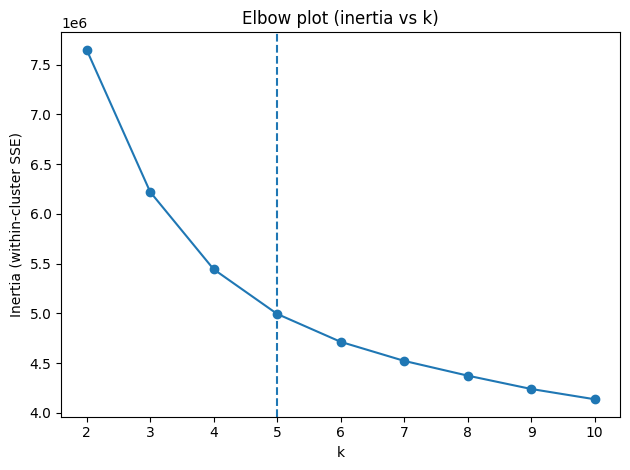

In [38]:
# 1. Elbow Method

use_minibatch = False  # set True for speed on very large data
Clusterer = MiniBatchKMeans if use_minibatch else KMeans

k_values = list(range(2, 11))
inertias = []
for k in k_values:
    if use_minibatch:
        km = Clusterer(n_clusters=k, n_init=5, random_state=0, batch_size=4096, max_iter=100)
    else:
        km = Clusterer(n_clusters=k, n_init=10, random_state=0, algorithm="elkan")
    km.fit(Xs)
    inertias.append(km.inertia_)

# --- Knee (elbow) detection by max distance to the line between endpoints ---
ks = np.array(k_values, dtype=float)
sse = np.array(inertias, dtype=float)
ks_n  = (ks  - ks.min())  / (ks.max()  - ks.min())
sse_n = (sse - sse.min()) / (sse.max() - sse.min())
p1, p2 = np.array([ks_n[0], sse_n[0]]), np.array([ks_n[-1], sse_n[-1]])
line = p2 - p1
norm = np.array([-line[1], line[0]])
dists = np.abs((ks_n - p1[0]) * norm[0] + (sse_n - p1[1]) * norm[1]) / np.linalg.norm(norm)
k_star = int(ks[np.argmax(dists)])

# --- Plot ---
plt.figure()
plt.plot(k_values, inertias, marker="o")
plt.axvline(k_star, linestyle="--")
plt.title("Elbow plot (inertia vs k)")
plt.xlabel("k"); plt.ylabel("Inertia (within-cluster SSE)")
plt.tight_layout()
plt.show()

**Interpretation:**

The elbow plot above shows a sharp decrease in within-cluster SSE (inertia) from k = 2 to k = 5, after which the improvement begins to flatten.

- From k = 2 → 5, inertia drops significantly (from ~7.6M to ~5.0M).

- Beyond k = 5, the reduction in SSE becomes marginal, indicating diminishing returns from adding more clusters.

In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np

Ks = range(2,9)
metrics = {}
for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=0)
    lab = km.fit_predict(Xs)  # Xs = your standardized features (counts+avgs)
    metrics[k] = {
        "sil": silhouette_score(Xs, lab, sample_size=min(10000, len(lab)), random_state=0),
        "ch":  calinski_harabasz_score(Xs, lab),
        "db":  davies_bouldin_score(Xs, lab),
        "size_min": np.bincount(lab).min(),
        "size_max": np.bincount(lab).max(),
    }

|  k  | Silhouette ↑ |     CH ↑    |   DB ↓   | Comment                                  |
| :-: | :----------: | :---------: | :------: | :--------------------------------------- |
|  2  |   **0.497**  | **103,711** | **0.96** | Strong separation and compact clusters   |
|  3  |     0.208    |    94,292   |   1.42   | Weaker structure                         |
|  4  |     0.186    |    84,504   |   1.45   | Further decline in quality               |
|  5  |     0.157    |    75,050   |   1.55   | No significant improvement               |
| 6–8 |     <0.15    |   <67,000   |   >1.56  | Increasing fragmentation and instability |

**Interpretation:**

- The silhouette score drops sharply after k = 2, indicating poorer separation as the number of clusters increases.

- CH index steadily decreases beyond k = 2, suggesting reduced between-cluster distinctiveness.

- DB index rises beyond k = 2, showing increasing overlap between clusters.

- Cluster sizes also become highly uneven as k grows (e.g., smallest cluster shrinks from ~21K at k=2 to only ~450 at k=8).

## Final selection: k = 2 and k = 5
To determine the optimal number of clusters (k), both the Elbow Method and multiple internal validation metrics were applied. The elbow plot initially suggested k = 5 based on the point of diminishing returns in inertia (within-cluster SSE). 

However, further evaluation using Silhouette, Calinski–Harabasz, and Davies–Bouldin scores indicated that the clustering quality is highest at k = 2. Specifically, k = 2 achieved the highest silhouette (0.497), highest CH index (103,711), and lowest DB index (0.96), suggesting the most compact and well-separated clusters. In contrast, higher k values resulted in smaller, less stable clusters with weaker separation.

We will explore two clustering scenarios (k = 2 and k = 5) to evaluate how different segmentation levels reveal distinct audience patterns and guide the next phase of analysis.

# K-Mean Clustering and Principal Component Analysis for Visualization

1. **K-Means Clustering**

K-Means clustering is an unsupervised learning algorithm that groups data points into k clusters based on similarity in their numerical features. It works by iteratively assigning each observation to the nearest cluster centroid and updating those centroids to minimize within-cluster variance. In this project, K-Means is applied to segment users by counts and average ratings by genres.

- Purpose is to identify natural audience segments without predefined labels.

- Each cluster represents a group of users who share similar viewing intensity and content taste.

- Setting k=2 allows us to distinguish between regular watchers (lower counts, higher ratings) and power users (higher counts, lower ratings).

2. **PCA for Visualization**

In this analysis, PCA is used only for visualization, not for clustering.

- It reduces the many input features to two components (PC1 and PC2) so the clusters can be plotted in 2D space.

- PC1 often reflects overall viewing volume or engagement level, while PC2 captures secondary differences such as rating patterns or genre preferences.


# Scenario 1: k = 2

In [40]:
feat_names = list(X.columns)
assert Xs.shape[1] == len(feat_names), "Feature count mismatch vs feat_names."

# Fit PCA 
try:
    _ = pca.components_
    assert pca.n_features_ == Xs.shape[1], "Existing PCA was fit on different features."
except Exception:
    pca = PCA(n_components=2, random_state=0).fit(Xs)

# Loadings and variance
loadings = pca.components_
var_pct  = pca.explained_variance_ratio_ * 100

TOPK = 5
for i in range(min(2, loadings.shape[0])):
    comp = loadings[i]
    top_idx = np.argsort(np.abs(comp))[::-1][:TOPK]
    print(f"\nTop {TOPK} features for PC{i+1} ({var_pct[i]:.2f}% variance):")
    for j in top_idx:
        print(f"  {feat_names[j]}: {comp[j]:+.3f}")



Top 5 features for PC1 (49.39% variance):
  cnt_Drama: +0.220
  cnt_Comedy: +0.219
  cnt_Action: +0.219
  cnt_Thriller: +0.218
  cnt_Romance: +0.217

Top 5 features for PC2 (12.87% variance):
  avg_Action: +0.278
  avg_Adventure: +0.275
  avg_Science Fiction: +0.271
  avg_Thriller: +0.266
  avg_Crime: +0.263


**PC1** (Volume): separates users by watching frequency, which dominates total variance in behavior.

PC1 (49.4% variance) captures overall viewing volume across genres. The top contributing features (cnt_Drama, cnt_Comedy, cnt_Action, cnt_Thriller, and cnt_Romance) all represent view counts, suggesting PC1 reflects how much content a user watches overall, regardless of genre.  **Users with higher PC1 scores are heavier watchers who consume more titles in nearly every genre.**

**PC2** (Ratings): adds nuance by reflecting differences in genre-specific satisfaction.

PC2 (12.9% variance) captures average rating behavior across genres. The strongest contributors (avg_Action, avg_Adventure, avg_Science Fiction, avg_Thriller, and avg_Crime) are average ratings, indicating PC2 represents how users rate content. **Higher PC2 scores may correspond to users who rate these genres more favorably, while lower scores may reflect users who are more critical or less engaged.**


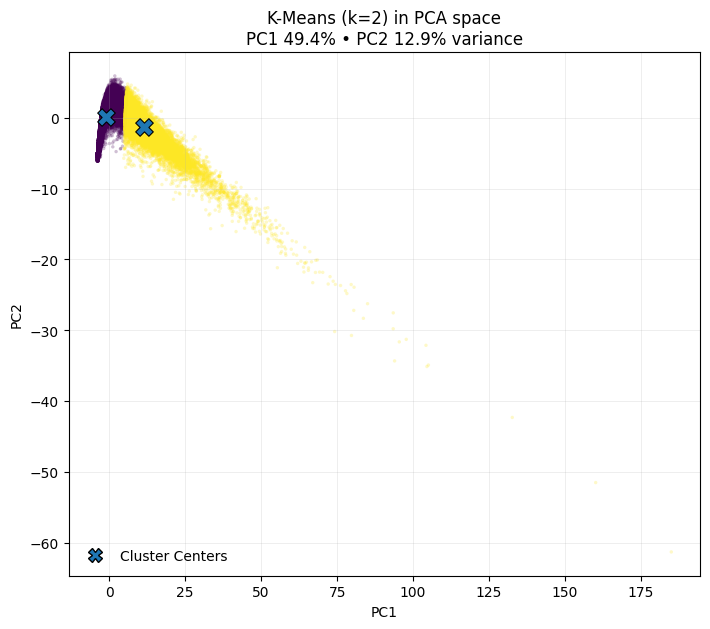

In [41]:
# 1) Fit K-Means on standardized features 
km = KMeans(n_clusters=2, n_init=10, random_state=0, algorithm="elkan").fit(Xs)
labels = km.labels_

# 2) PCA for visualization only
pca = PCA(n_components=2, random_state=0)
XY = pca.fit_transform(Xs)
centers_2d = pca.transform(km.cluster_centers_)
var = pca.explained_variance_ratio_       # [pc1, pc2]

# 3) Balanced subsample so minority cluster is visible
rng = np.random.default_rng(0)
idxs = []
n_per = 40000  # tweak for speed/clarity
for k in np.unique(labels):
    k_idx = np.where(labels == k)[0]
    take = min(n_per, len(k_idx))
    idxs.append(rng.choice(k_idx, size=take, replace=False))
idx = np.concatenate(idxs)

# 4) Plot
plt.figure(figsize=(7.2, 6.4))
scatter = plt.scatter(
    XY[idx, 0], XY[idx, 1],
    c=labels[idx], s=6, alpha=0.25, linewidths=0, rasterized=True
)

plt.scatter(
    centers_2d[:, 0], centers_2d[:, 1],
    s=160, marker="X", edgecolor="black", linewidths=0.8, zorder=3
)

plt.title(f"K-Means (k=2) in PCA space\nPC1 {var[0]*100:.1f}% • PC2 {var[1]*100:.1f}% variance")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.25, linewidth=0.6)

# Custom legend
handles = [
    Line2D([0], [0], marker='X', linestyle='None', label='Cluster Centers', markersize=10, markeredgecolor='black')
]
plt.legend(handles=handles, frameon=False, loc="lower left")

plt.tight_layout()
plt.show()

### Quick observation: <br> 

When combining both movie count (cnt_) and average rating (avg_) features in the K-Means clustering, the resulting separation appears to be driven primarily by viewing frequency rather than audience preference. 

As shown in the PCA visualization, PC1, which explains 49.4% of the variance, is dominated by count-related features such as cnt_Drama, cnt_Comedy, and cnt_Action, indicating that this dimension mainly captures overall viewing volume. In contrast, PC2 (12.9% of the variance) is influenced by rating-based features like avg_Action, avg_Adventure, and avg_Science Fiction, reflecting differences in how users rate the genres they watch. 

The sharp division between clusters along PC1 therefore suggests that the model is clustering users largely by how frequently they engage with movies, rather than by their underlying taste or preference patterns.

# Scenario 2: k = 5

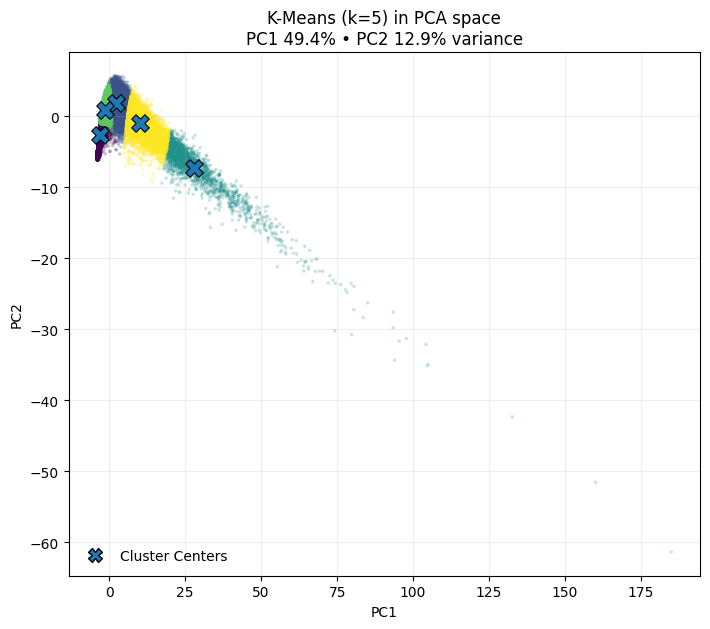

In [42]:
# 1) Fit K-Means on standardized features
km = KMeans(n_clusters=5, n_init=10, random_state=0, algorithm="elkan").fit(Xs)
labels = km.labels_

# 2) PCA for visualization only
pca = PCA(n_components=5, random_state=0)
XY = pca.fit_transform(Xs)
centers_2d = pca.transform(km.cluster_centers_)
var = pca.explained_variance_ratio_       # [pc1, pc2]

# 3) Balanced subsample so minority cluster is visible
rng = np.random.default_rng(0)
idxs = []
n_per = 40000  # tweak for speed/clarity
for k in np.unique(labels):
    k_idx = np.where(labels == k)[0]
    take = min(n_per, len(k_idx))
    idxs.append(rng.choice(k_idx, size=take, replace=False))
idx = np.concatenate(idxs)

# 4) Plot
plt.figure(figsize=(7.2, 6.4))
scatter = plt.scatter(
    XY[idx, 0], XY[idx, 1],
    c=labels[idx], s=6, alpha=0.25, linewidths=0, rasterized=True
)

plt.scatter(
    centers_2d[:, 0], centers_2d[:, 1],
    s=160, marker="X", edgecolor="black", linewidths=0.8, zorder=3
)

plt.title(f"K-Means (k=5) in PCA space\nPC1 {var[0]*100:.1f}% • PC2 {var[1]*100:.1f}% variance")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.25, linewidth=0.6)

# Custom legend
handles = [
    Line2D([0], [0], marker='X', linestyle='None', label='Cluster Centers', markersize=10, markeredgecolor='black')
]
plt.legend(handles=handles, frameon=False, loc="lower left")

plt.tight_layout()
plt.show()

### Quick observations:

Thus, even with more clusters, the segmentation largely reflects users’ viewing frequency rather than distinct genre preferences. Since this result does not focus on audience taste (genres preference), **the next step is to pivot the analysis toward using average rating features only, allowing PC1 and PC2 to better capture differences in users’ genre preferences.**

After observing that the previous clustering results were dominated by viewing frequency rather than user preference, the analysis is now refocused to use average rating features only. By removing count-based variables, this approach aims to better capture differences in users’ taste and sentiment toward various genres. The new PCA visualization (ratings-only K-Means, k = 2 and k = 5) reflects how audiences differ in their rating patterns across genres, rather than how often they watch movies.

## Scenario 3: k = 2 (PC1 and PC2 based on ratings only)

k=2 silhouette: 0.225


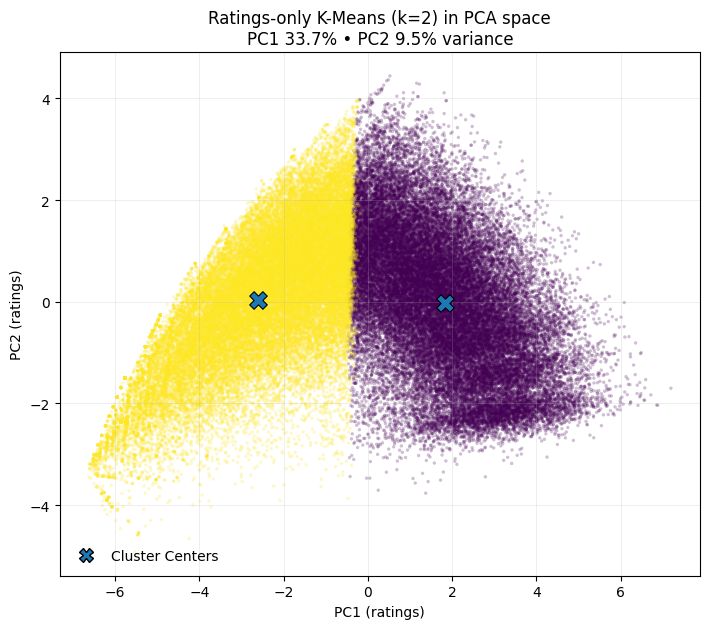

In [43]:
K = 2                          # try 2 and 5
SUBSAMPLE_PER_CLUSTER = 40000  # for balanced plotting

# 1) Select ratings-only features
avg_cols = [c for c in user_df.columns if c.startswith("avg_")]
X = user_df[avg_cols].astype(float)

# 2) Simple imputation + standardization (ratings only)
X = X.fillna(X.mean())         # per-genre mean impute
scaler = StandardScaler()
Xs = scaler.fit_transform(X.values)

# 3) K-Means on ratings-only space
km = KMeans(n_clusters=K, n_init=10, random_state=0, algorithm="elkan").fit(Xs)
labels = km.labels_
sil = silhouette_score(Xs, labels, sample_size=min(10000, len(labels)), random_state=0)
print(f"k={K} silhouette: {sil:.3f}")

# 4) PCA ONLY for visualization (still using ratings-only features)
pca = PCA(n_components=2, random_state=0)
XY = pca.fit_transform(Xs)
centers_2d = pca.transform(km.cluster_centers_)
var = pca.explained_variance_ratio_

# 5) Balanced subsample for plotting
rng = np.random.default_rng(0)
take = []
for k in np.unique(labels):
    k_idx = np.where(labels == k)[0]
    n = min(SUBSAMPLE_PER_CLUSTER, len(k_idx))
    take.append(rng.choice(k_idx, size=n, replace=False))
plot_idx = np.concatenate(take) if take else np.arange(len(labels))

# 6) Plot
plt.figure(figsize=(7.2, 6.4))
plt.scatter(XY[plot_idx, 0], XY[plot_idx, 1],
            c=labels[plot_idx], s=6, alpha=0.25, linewidths=0, rasterized=True)

plt.scatter(centers_2d[:, 0], centers_2d[:, 1],
            s=160, marker="X", edgecolor="black", linewidths=0.8, zorder=3)

plt.title(f"Ratings-only K-Means (k={K}) in PCA space\nPC1 {var[0]*100:.1f}% • PC2 {var[1]*100:.1f}% variance")
plt.xlabel("PC1 (ratings)")
plt.ylabel("PC2 (ratings)")
plt.grid(alpha=0.25, linewidth=0.6)

handles = [Line2D([0], [0], marker='X', linestyle='None',
           label='Cluster Centers', markersize=10, markeredgecolor='black')]
plt.legend(handles=handles, frameon=False, loc="lower left")

plt.tight_layout()
plt.show()


In [44]:
# pca.components_[i, j] = loading of feature j on PC (i+1)
loadings = pd.DataFrame(
    pca.components_.T,
    index=avg_cols,
    columns=["PC1", "PC2"]
)
loadings["feature"] = loadings.index
loadings["genre"] = loadings["feature"].str.replace(r"^avg_", "", regex=True)
loadings["abs_PC1"] = loadings["PC1"].abs()
loadings["abs_PC2"] = loadings["PC2"].abs()

# ---- Top 5 (by absolute magnitude) for each PC ----
top5_pc1 = loadings.sort_values("abs_PC1", ascending=False).head(5)[
    ["genre", "PC1", "abs_PC1"]
]
top5_pc2 = loadings.sort_values("abs_PC2", ascending=False).head(5)[
    ["genre", "PC2", "abs_PC2"]
]

print(f"Explained variance: PC1 = {pca.explained_variance_ratio_[0]*100:.1f}% | "
      f"PC2 = {pca.explained_variance_ratio_[1]*100:.1f}%\n")

print("Top 5 contributors to PC1 (ratings-only):")
display(top5_pc1.style.format({"PC1": "{:+.3f}", "abs_PC1": "{:.3f}"}))

print("\nTop 5 contributors to PC2 (ratings-only):")
display(top5_pc2.style.format({"PC2": "{:+.3f}", "abs_PC2": "{:.3f}"}))

# ---- (Optional) also see signed TOP+/TOP− separately for each PC ----
# This can help interpret direction (higher vs lower on the component).
top5_pc1_pos = loadings.sort_values("PC1", ascending=False).head(5)[["genre", "PC1"]]
top5_pc1_neg = loadings.sort_values("PC1", ascending=True).head(5)[["genre", "PC1"]]
top5_pc2_pos = loadings.sort_values("PC2", ascending=False).head(5)[["genre", "PC2"]]
top5_pc2_neg = loadings.sort_values("PC2", ascending=True).head(5)[["genre", "PC2"]]

print("\nPC1 — Top +5 (positive direction):")
display(top5_pc1_pos.style.format({"PC1": "{:+.3f}"}))
print("PC1 — Top −5 (negative direction):")
display(top5_pc1_neg.style.format({"PC1": "{:+.3f}"}))

print("\nPC2 — Top +5 (positive direction):")
display(top5_pc2_pos.style.format({"PC2": "{:+.3f}"}))
print("PC2 — Top −5 (negative direction):")
display(top5_pc2_neg.style.format({"PC2": "{:+.3f}"}))


Explained variance: PC1 = 33.7% | PC2 = 9.5%

Top 5 contributors to PC1 (ratings-only):


,genre,PC1,abs_PC1
avg_Fantasy,Fantasy,+0.258,0.258
avg_Adventure,Adventure,+0.252,0.252
avg_Science Fiction,Science Fiction,+0.252,0.252
avg_Mystery,Mystery,+0.248,0.248
avg_Family,Family,+0.246,0.246



Top 5 contributors to PC2 (ratings-only):


,genre,PC2,abs_PC2
avg_Drama,Drama,+0.334,0.334
avg_Thriller,Thriller,+0.322,0.322
avg_Foreign,Foreign,-0.281,0.281
avg_Animation,Animation,-0.274,0.274
avg_TV Movie,TV Movie,-0.272,0.272



PC1 — Top +5 (positive direction):


,genre,PC1
avg_Fantasy,Fantasy,+0.258
avg_Adventure,Adventure,+0.252
avg_Science Fiction,Science Fiction,+0.252
avg_Mystery,Mystery,+0.248
avg_Family,Family,+0.246


PC1 — Top −5 (negative direction):


,genre,PC1
avg_TV Movie,TV Movie,+0.153
avg_Drama,Drama,+0.163
avg_Foreign,Foreign,+0.174
avg_Comedy,Comedy,+0.205
avg_War,War,+0.207



PC2 — Top +5 (positive direction):


,genre,PC2
avg_Drama,Drama,+0.334
avg_Thriller,Thriller,+0.322
avg_Action,Action,+0.266
avg_Comedy,Comedy,+0.250
avg_Romance,Romance,+0.201


PC2 — Top −5 (negative direction):


,genre,PC2
avg_Foreign,Foreign,-0.281
avg_Animation,Animation,-0.274
avg_TV Movie,TV Movie,-0.272
avg_War,War,-0.271
avg_Documentary,Documentary,-0.242


### Interpretation: 

- PC1 (33.7% variance) primarily represents users’ overall preference toward fantasy, adventure, science fiction, mystery, and family genres. Higher PC1 scores indicate users who tend to give more favorable ratings to these imaginative or story-driven genres, while lower PC1 scores suggest weaker engagement with them.

- PC2 (9.5% variance) captures contrasting tendencies between drama/thriller lovers and those who rate foreign, animation, or TV movies more highly. A higher PC2 value corresponds to users who prefer intense, plot-driven genres (e.g., drama and thriller), whereas lower PC2 values are associated with lighter or stylistically different genres such as animation and foreign films.

## Scenario 4: k = 5 (PC1 and PC2 based on ratings only)

k=5 silhouette: 0.109
Cluster sizes: {0: np.int64(57188), 1: np.int64(70813), 2: np.int64(36158), 3: np.int64(65504), 4: np.int64(36185)}


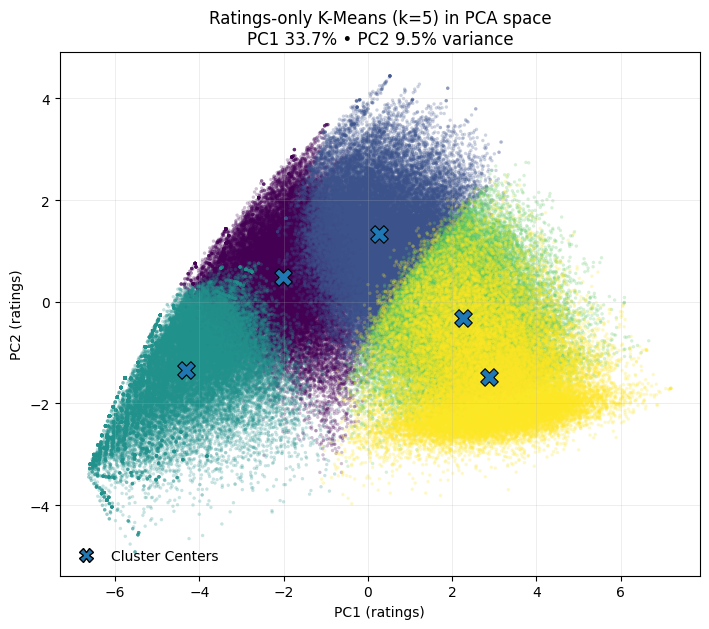

In [45]:
K = 5                          # <- set k=5
SUBSAMPLE_PER_CLUSTER = 40000  # for balanced plotting

# 1) Select ratings-only features
avg_cols = [c for c in user_df.columns if c.startswith("avg_")]
X = user_df[avg_cols].astype(float)

# 2) Simple imputation + standardization (ratings only)
X = X.fillna(X.mean())         # per-genre mean impute
scaler = StandardScaler()
Xs = scaler.fit_transform(X.values)

# 3) K-Means on ratings-only space
km = KMeans(n_clusters=K, n_init=10, random_state=0, algorithm="elkan").fit(Xs)
labels = km.labels_
sizes = np.bincount(labels)
sil = silhouette_score(Xs, labels, sample_size=min(10000, len(labels)), random_state=0)
print(f"k={K} silhouette: {sil:.3f}")
print("Cluster sizes:", dict(zip(range(K), sizes.astype(int))))

# 4) PCA ONLY for visualization (still using ratings-only features)
pca = PCA(n_components=2, random_state=0)
XY = pca.fit_transform(Xs)
centers_2d = pca.transform(km.cluster_centers_)
var = pca.explained_variance_ratio_

# 5) Balanced subsample for plotting
rng = np.random.default_rng(0)
take = []
for k in np.unique(labels):
    k_idx = np.where(labels == k)[0]
    n = min(SUBSAMPLE_PER_CLUSTER, len(k_idx))
    take.append(rng.choice(k_idx, size=n, replace=False))
plot_idx = np.concatenate(take) if take else np.arange(len(labels))

# 6) Plot
plt.figure(figsize=(7.2, 6.4))
plt.scatter(
    XY[plot_idx, 0], XY[plot_idx, 1],
    c=labels[plot_idx], s=6, alpha=0.25, linewidths=0, rasterized=True
)

plt.scatter(
    centers_2d[:, 0], centers_2d[:, 1],
    s=160, marker="X", edgecolor="black", linewidths=0.8, zorder=3
)

plt.title(f"Ratings-only K-Means (k={K}) in PCA space\nPC1 {var[0]*100:.1f}% • PC2 {var[1]*100:.1f}% variance")
plt.xlabel("PC1 (ratings)")
plt.ylabel("PC2 (ratings)")
plt.grid(alpha=0.25, linewidth=0.6)

handles = [Line2D([0], [0], marker='X', linestyle='None', label='Cluster Centers',
                  markersize=10, markeredgecolor='black')]
plt.legend(handles=handles, frameon=False, loc="lower left")

plt.tight_layout()
plt.show()

### Quick observations: 

The boundaries among the five clusters suggest that users exhibit diverse rating tendencies. This distinct segmentation makes the k = 5 solution particularly interesting for deeper analysis, as it allows for profiling each cluster’s unique preference style and identifying potential audience segments with shared taste patterns.

# Analysis

Following the formation of five distinct clusters (Cluster 0–4), the next stage of analysis focuses on understanding audience engagement and preference patterns within each group. Specifically, two key metrics will be examined:

- Average movie counts: measuring how many movies an average user in each cluster has watched, which reflects overall engagement intensity.

- Average rating per genre: calculating the mean rating each cluster gives across genres, providing insight into differences in audience taste and satisfaction.

Together, these analyses will reveal how viewing activity and rating behavior vary across clusters, helping to characterize each audience segment more precisely.

## Measurement 1: Average Movie Counts

To further understand audience engagement across clusters, the user_df dataset containing the userId and cluster columns will be merged with the original dataset that includes all original_title information. This step enables grouping users by their assigned cluster and calculating, on average, how many unique movie titles each cluster’s audience has watched. 

In [46]:
user_df["cluster"] = labels          # now user_df stores the 5-cluster info
# (optional) keep a slim view:
cluster_df = user_df[["userId", "cluster"]].copy()
cluster_df.head()

,userId,cluster
0,1,0
1,2,1
2,3,0
3,4,1
4,5,1


In [47]:
# left-join by userId
user_df_by_clusters_1 = dataset.merge(cluster_df, on="userId", how="left")

In [48]:
# source
df = user_df_by_clusters_1

# keep only these columns
keep = ["userId", "cluster", "original_title"]

# sanity check
missing = [c for c in keep if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns in user_df_by_clusters_1: {missing}")

# select (and drop exact duplicates)
user_df_by_clusters_count = (
    df.loc[:, keep]
      .drop_duplicates()      # drop if the same userId/cluster/title repeats
      .reset_index(drop=True)
)

print(user_df_by_clusters_count)


          userId  cluster                        original_title
0              1        0                Trois couleurs : Rouge
1              1        0                Les Quatre Cents Coups
2              1        0                  Sleepless in Seattle
3              1        0                          Rocky Balboa
4              1        0                         Fools Rush In
...          ...      ...                                   ...
11347168  270896        3                                  Boat
11347169  270896        3                               In Time
11347170  270896        3                                 مسافر
11347171  270896        3                   Shuang ma lian huan
11347172  270896        3  Confession of a Child of the Century

[11347173 rows x 3 columns]


In [49]:
df = user_df_by_clusters_count  # has: userId, cluster, original_title

# total titles per cluster (row count)
titles_per_cluster = df.groupby("cluster").size()

# unique users per cluster
users_per_cluster = df.groupby("cluster")["userId"].nunique()

# average titles watched per user in each cluster
avg_titles_per_user = (titles_per_cluster / users_per_cluster).round(2)

print(avg_titles_per_user)


cluster
0      9.23
1     17.70
2      4.83
3     68.53
4    135.47
dtype: float64


The average number of movies watched varies substantially across clusters, indicating distinct engagement levels among user groups. Cluster 4 represents highly active viewers, watching an average of about 135 titles, followed by Cluster 3 with 68 titles. In contrast, Clusters 0, 1, and 2 exhibit lower activity, averaging between 5 and 18 titles per user. 

This gradient suggests a clear behavioral segmentation, where a small subset of users are highly engaged movie watchers, while the majority demonstrate more casual or selective viewing habits.

## Measurement 2: Average Rating per Genre

The second measurement of the analysis focuses on measuring average ratings by genre for each cluster. The goal is to calculate the mean rating across 20 genres within each audience segment to better understand their tastes/preferences. 

To achieve this, the user_df dataset containing the userId and cluster columns is merged with the dataset that includes all one-hot encoded genre columns and rating information. After merging, users are grouped by their assigned cluster, and the average rating for each genre is computed.

In [50]:
cluster_df = user_df[["userId", "cluster"]].copy()
user_df_no_cluster_column = user_df.drop(columns=["cluster"])
user_df_by_clusters_column = user_df_no_cluster_column.merge(cluster_df, on="userId", how="left")

In [51]:
# Use the frame that ALREADY has 'cluster'
df = user_df_by_clusters_column  # adjust if your variable is named differently

# 1) Collect columns (ratings averages)
avg_cols = [c for c in df.columns if c.startswith("avg_")]
need = ["userId", "cluster"] + avg_cols

# (optional) sanity check
missing = [c for c in ["userId", "cluster"] if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in df: {missing}")

# 2) Select and sort so clusters are grouped together
out_avg = (
    df.loc[:, need]
      .sort_values(["cluster", "userId"], kind="stable")
      .reset_index(drop=True)
)

# 3) Quick checks
print(out_avg["cluster"].value_counts().sort_index())
print("Shape:", out_avg.shape)

# 4) Save to CSV
out_avg.to_csv("users_by_cluster_avg_ratings.csv", index=False)


cluster
0    57188
1    70813
2    36158
3    65504
4    36185
Name: count, dtype: int64
Shape: (265848, 22)


In [52]:
# mean of avg_* per genre within each cluster
out_avg = (
    df.groupby("cluster", as_index=True)[avg_cols]
      .mean()
      .round(2)
)

out_avg.head() # rows = clusters, cols = avg_* genres

,avg_Action,avg_Adventure,avg_Animation,avg_Comedy,avg_Crime,avg_Documentary,avg_Drama,avg_Family,avg_Fantasy,avg_Foreign,avg_History,avg_Horror,avg_Music,avg_Mystery,avg_Romance,avg_Science Fiction,avg_TV Movie,avg_Thriller,avg_War,avg_Western
cluster,,,,,,,,,,,,,,,,,,,,
0,2.96,1.89,0.42,3.05,2.48,0.49,3.51,0.81,1.01,0.27,0.84,1.12,0.71,1.83,2.59,1.69,0.19,3.34,0.47,0.74
1,3.73,3.63,0.60,3.70,3.44,0.91,3.78,1.80,2.54,0.38,1.42,2.60,1.14,3.51,3.52,3.63,0.20,3.78,0.62,1.12
2,0.97,0.99,0.24,1.83,0.85,0.31,2.57,0.49,0.59,0.14,0.44,0.67,0.35,0.78,1.46,0.89,0.09,1.18,0.22,0.27
3,3.73,3.65,2.59,3.70,3.70,2.98,3.71,3.37,3.58,1.17,3.23,3.59,3.14,3.75,3.72,3.64,0.06,3.74,2.62,2.49
4,3.70,3.63,2.68,3.70,3.67,2.99,3.69,3.27,3.47,2.82,3.50,3.38,2.97,3.69,3.65,3.61,3.85,3.70,2.70,3.46


## Heat map visualization

To visualize these results, a heat map can be used to display the average genre ratings across clusters. 

- Each row represents a cluster.

- Each column represents a genre.

- Color intensity indicating the mean rating level. 

This visualization makes it easy to identify which genres each audience segment rates more favorably or critically, highlighting clear contrasts in taste patterns and genre preferences across clusters.

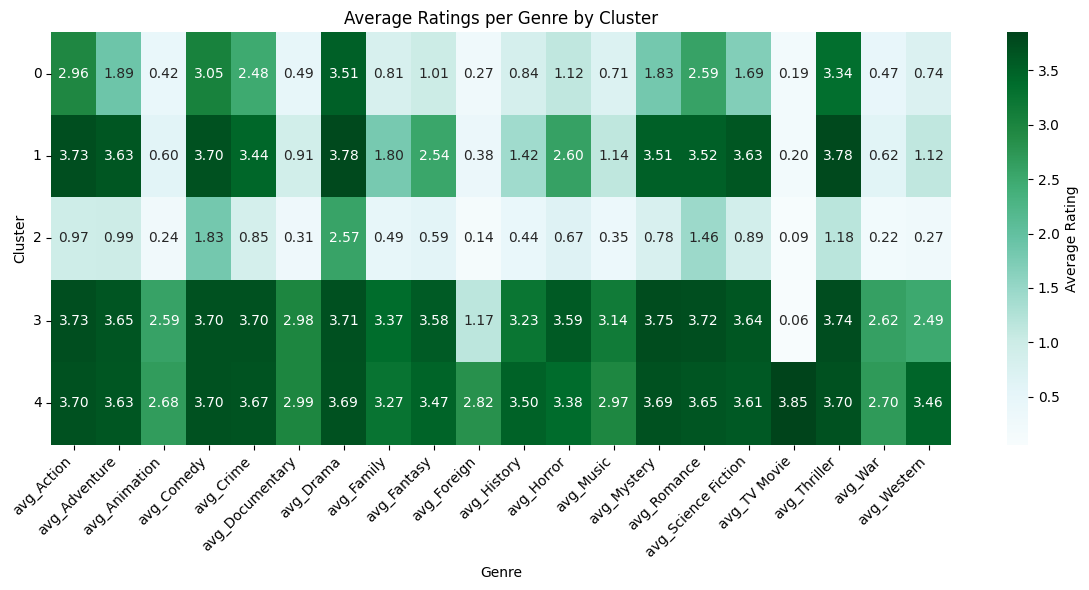

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(
    out_avg,              # rows: clusters, cols: avg_* genres
    cmap="BuGn",
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Average Rating"}
)
plt.title("Average Ratings per Genre by Cluster")
plt.xlabel("Genre")
plt.ylabel("Cluster")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Finding Summary

| **Cluster**                                         | **Profile Summary**                                                                                                 | **High-Rated Genres (≥3)**                                                               | **Content / Product Strategy**                                                                                                       | **Marketing & Engagement Actions**                                                                                                                                |
| --------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------ | ----------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **New Explorers**                        | Avg **9 movies/user**. <br> Light casual users showing moderate interest, especially in emotional and mainstream genres. | *Drama, Thriller, Comedy*                                                                | Personalize based on top genres to reduce choice overload. Curate a “Quick Picks” or “Tonight’s Watch” list with trending titles.    | Targeted push notifications (Drama/Thriller), onboarding playlists (“Start with Top 5 in Comedy”), and watch-streak or first-10 rewards to encourage consistency. |
| **Expanding Enthusiasts**                          | Avg **18 movies/user**. <br> Positive sentiment with moderate frequency; open to multiple genres.                        | *9/20 genres* high-rated (Drama, Romance, Thriller, Action)                              | Encourage cross-genre exploration (“If you liked Drama, try Thriller”). Highlight series/franchises to boost repeat engagement.      | Run personalized discovery campaigns, introduce achievement badges, and create genre-challenge events to sustain interest.                                        |
| **Quiet Viewers (Churn Risk)**               | Avg **5 movies/user** <br> Lowest engagement and low satisfaction (<3 ratings across genres).                           | *None consistently ≥3*                                                                   | Focus on quality-over-quantity: promote only top-rated or editor-curated titles. Simplify recommendations to avoid overwhelm.        | Send re-engagement campaigns (“We think you’ll love these picks”), collect feedback via surveys, and offer watch credits to reactivate usage.                     |
| **Loyalists (Heavy Positive Viewers)** | Avg **69 movies/user** <br> Strong engagement and broad satisfaction across genres.                                     | *14/20 genres* (except for TV Movie, Foreign, Western and Animation - rated below 2.5)         | Implement advanced personalization; recommend new releases, niche titles, and sequels in their preferred genres.                     | Offer early access/previews, social sharing features, and VIP reward programs for loyal users.                                                                    |
| **Premium Loyalists**                            | Avg **135 movies/user** <br> The most active and satisfied viewers; high ratings across nearly all genres.              | *15/20 genres* (all genres were rated above 2.5) | Recommend diverse, long-form, and international content to sustain novelty. Apply hybrid recommendation models (content + behavior). | Create VIP or ambassador programs, beta-tester opportunities, and personalized “Year in Review” summaries to reinforce connection and loyalty.                    |